🚀 Cinnamon Price Forecasting - Enhanced Inference Mode
🌿 Welcome to the Cinnamon Price Forecasting System
📂 AVAILABLE MODELS:
1. cinnamon_model_20250929_150355
   📅 Created: 20250929 15:03
2. cinnamon_model_20250926_160758
   📅 Created: 20250926 16:07
3. cinnamon_model_20250926_153157
   📅 Created: 20250926 15:31
4. cinnamon_model_20250925_161931
   📅 Created: 20250925 16:19
5. cinnamon_model_20250925_150447
   📅 Created: 20250925 15:04
6. cinnamon_model_20250924_114850
   📅 Created: 20250924 11:48
7. cinnamon_model_20250923_183211
   📅 Created: 20250923 18:32
8. cinnamon_model_20250923_151802
   📅 Created: 20250923 15:18
✅ Selected: cinnamon_model_20250929_150355

📂 Loading model from: cinnamon_models\cinnamon_model_20250929_150355
✅ Keras model loaded
✅ Scalers loaded
✅ Label encoders loaded
🎉 Model successfully loaded!
📊 Performance: MAE=67.34, RMSE=101.93, R²=0.9859

📊 Loading data from C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv...
Initi

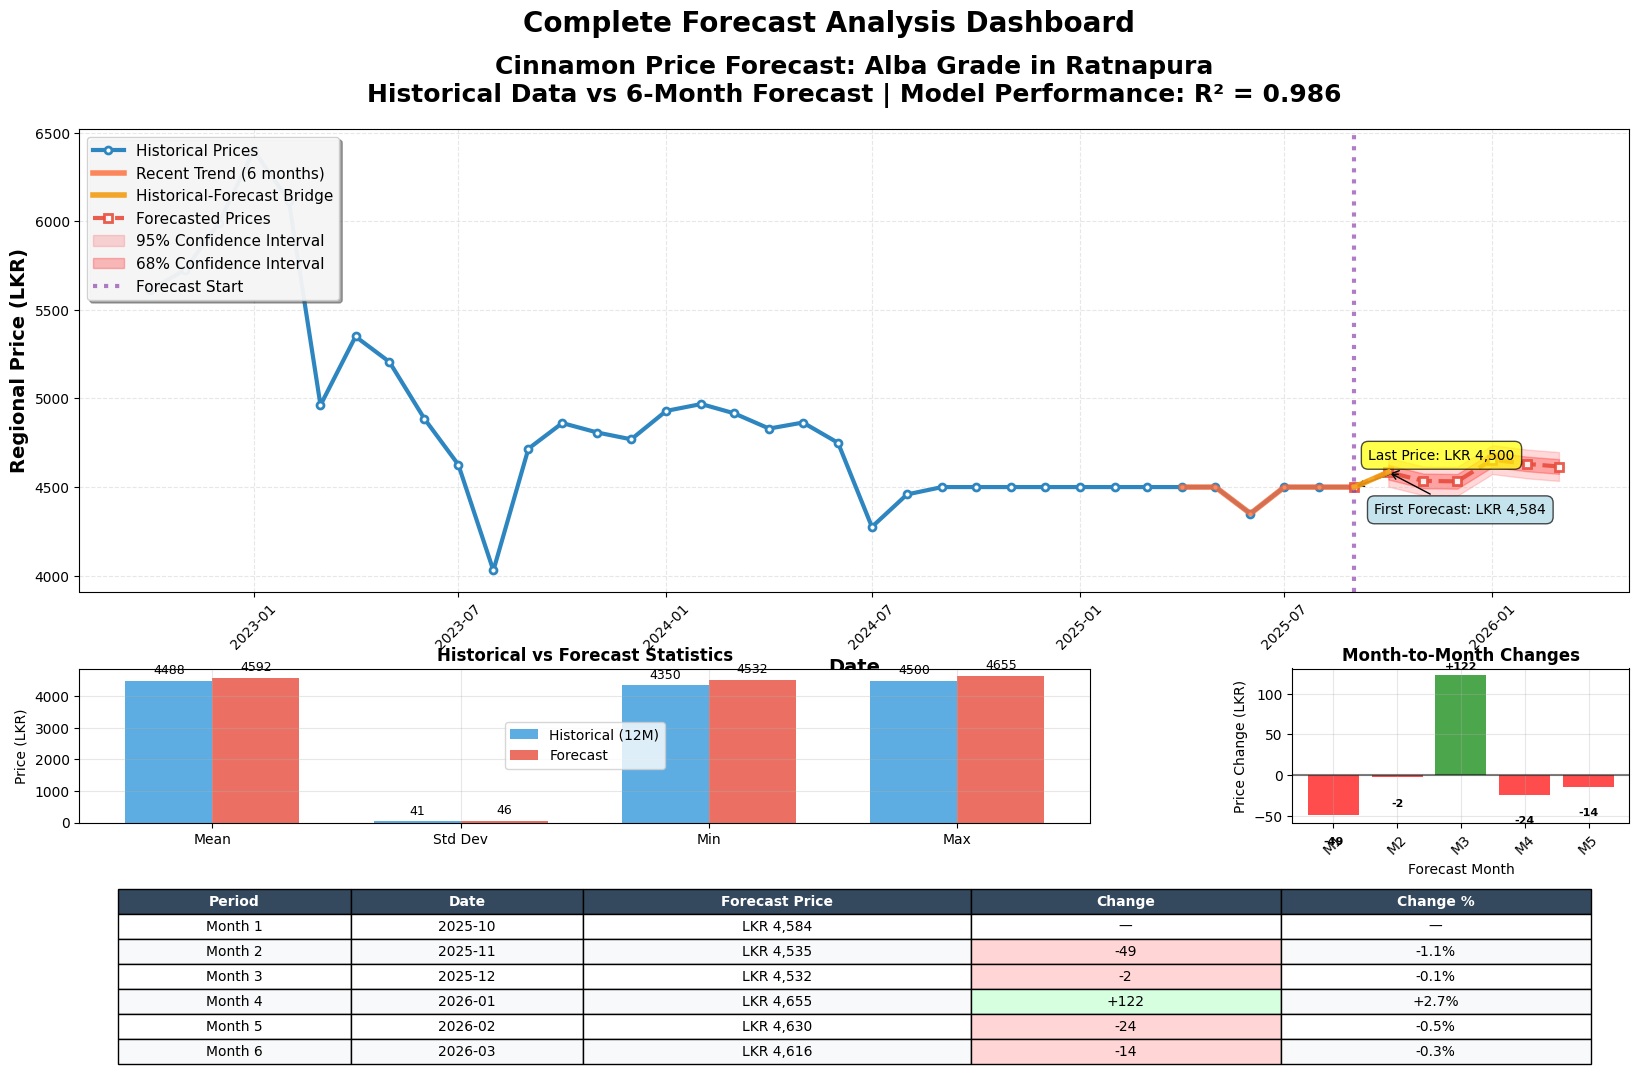


COMPREHENSIVE FORECAST SUMMARY
Target: Alba Grade in Ratnapura
Forecast Period: 2025-10 to 2026-03
Model Performance: R² = 0.9859

📈 KEY METRICS:
   • Last Historical Price: LKR 4,500.00
   • Average Forecast Price: LKR 4,592.03
   • Price Range: LKR 4,532.25 - LKR 4,654.56
   • Standard Deviation: LKR 46.33
   • Volatility: 1.0%

🔮 TREND ANALYSIS:
   • Overall Trend: 📈 INCREASING
   • Trend Strength: Mild
   • Total Change: LKR +31.91 (+0.7%)
   • Average Monthly Change: LKR +5.32
   • Price Volatility Risk: Low


🎮 FORECAST OPTIONS:
1. 📊 Single Detailed Forecast (Enhanced Dashboard)
2. 📈 Regional Price Comparison (Same Grade, Multiple Regions)
3. 🔍 Quick Forecast Preview (Simple)
4. 📋 Show Available Data Summary
5. 🚪 Exit
👋 Thank you for using the Cinnamon Price Forecasting System!


In [1]:
# Cinnamon Price Forecasting - Enhanced Inference & Plotting
# This notebook loads saved models and generates comprehensive forecasts without retraining

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json

warnings.filterwarnings("ignore")

# Configuration
SEQUENCE_LENGTH = 12
MODEL_DIR = 'cinnamon_models'
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv'

# Global variables for preprocessors
scaler_features = None
scaler_target = None
label_encoders = {}
model_config = {}

print("🚀 Cinnamon Price Forecasting - Enhanced Inference Mode")
print("=" * 60)

def list_available_models(model_dir=MODEL_DIR):
    """List all available saved models"""
    if not os.path.exists(model_dir):
        print(f"❌ Model directory not found: {model_dir}")
        return []

    model_folders = []
    for item in os.listdir(model_dir):
        item_path = os.path.join(model_dir, item)
        if os.path.isdir(item_path):
            # Check if it contains required model files
            required_files = ['lstm_model.keras', 'scalers.pkl', 'label_encoders.pkl', 'model_config.json']
            if all(os.path.exists(os.path.join(item_path, f)) for f in required_files):
                model_folders.append(item)

    return sorted(model_folders, reverse=True)  # Most recent first

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders, model_config

    print(f"📂 Loading model from: {model_path}")

    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")

        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")

        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")

        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            model_config = json.load(f)

        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={model_config['training_info']['mae']:.2f}, "
              f"RMSE={model_config['training_info']['rmse']:.2f}, "
              f"R²={model_config['training_info']['r2']:.4f}")

        if model_config['training_info'].get('used_hyperparameter_tuning', False):
            print("🔍 This model was trained using hyperparameter tuning")
            if 'best_hyperparameters' in model_config:
                print("📋 Best hyperparameters:")
                for param, value in model_config['best_hyperparameters'].items():
                    print(f"   • {param}: {value}")

        return model, model_config

    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None

def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset (same as training)"""
    print(f"📊 Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    df.loc[df['Is_Active_Region'] == 0, 'Regional_Price'] = df.loc[df['Is_Active_Region'] == 0, 'National_Price']
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables using loaded encoders
    for col in ['Grade', 'Region']:
        if col in label_encoders:
            df[f'{col}_encoded'] = label_encoders[col].transform(df[col])
        else:
            print(f"⚠️ Warning: No encoder found for {col}")

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    return df

# Define feature columns (same as training)
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
    'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter','Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'National_Price_lag_1', 'National_Price_lag_3', 'National_Price_lag_6', 'National_Price_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12'
]

def forecast_prices(model, df, grade, region, months_ahead=12):
    """Generate price forecasts for specified grade and region"""
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')

    if len(subset) == 0:
        print(f"❌ No data found for {grade} in {region}")
        return None, None

    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')

    print(f"🔮 Generating {months_ahead}-month forecast starting from {last_date.strftime('%Y-%m')}")

    # Generate future rows with realistic seasonal patterns
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter

        # Add seasonal patterns and random variations
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features for extended data
    for col in ['Regional_Price','National_Price','Temperature','Rainfall']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(
                lambda x: x.rolling(window).mean()
            )

    # Select exactly the features used during training
    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]
    missing_cols = [c for c in TRAIN_FEATURE_COLS if c not in extended_df.columns]
    if missing_cols:
        print(f"⚠️ Warning: Missing feature columns: {missing_cols}")

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    print("Generating sequential forecasts...")
    for i in range(months_ahead):
        # Get the sequence needed for prediction
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]

        if len(current_data) < SEQUENCE_LENGTH:
            # Pad with last known data if needed
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        # Prepare sequence for model
        sequence = current_data[feature_cols].fillna(method='ffill').fillna(method='bfill').values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        # Make prediction
        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        # Update the extended dataframe with the new prediction
        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    print(f"✅ Forecast generation completed!")
    return forecasts, future_dates

def plot_forecast_results(df, model, grade, region, months_ahead=12, show_recent_months=36):
    """Plot enhanced interactive historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')

        if len(subset) == 0:
            print(f"❌ No data found for {grade} in {region}")
            return None, None

        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)

        if forecasts is None:
            return None, None

        # Create enhanced figure with subplots
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 2, height_ratios=[3, 1, 1], width_ratios=[3, 1],
                             hspace=0.3, wspace=0.3)

        # Main forecast plot
        ax_main = fig.add_subplot(gs[0, :])

        # Filter to show only recent historical data for better visibility
        recent_subset = subset.tail(show_recent_months) if len(subset) > show_recent_months else subset

        # Plot historical data with enhanced styling
        ax_main.plot(recent_subset['Month'], recent_subset['Regional_Price'],
                    label='Historical Prices', linewidth=3, color='#2E86C1',
                    marker='o', markersize=5, markerfacecolor='white', markeredgewidth=2)

        # Highlight recent trend (last 6 months)
        if len(recent_subset) >= 6:
            recent_6m = recent_subset.tail(6)
            ax_main.plot(recent_6m['Month'], recent_6m['Regional_Price'],
                        linewidth=4, color='#FF6B35', alpha=0.8,
                        label='Recent Trend (6 months)')

        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]

        # Enhanced bridge connection
        ax_main.plot([last_historical_date, first_forecast_date],
                    [last_historical_price, first_forecast_price],
                    color='#F39C12', linewidth=4, linestyle='-', alpha=0.9,
                    label='Historical-Forecast Bridge', zorder=5)

        # Plot forecasts with enhanced styling
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)

        ax_main.plot(extended_forecast_dates, extended_forecasts,
                    label='Forecasted Prices', linewidth=3, color='#E74C3C',
                    marker='s', markersize=6, linestyle='--', alpha=0.9,
                    markerfacecolor='white', markeredgewidth=2)

        # Enhanced confidence intervals with multiple levels
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))

            # 95% Confidence Interval
            upper_95 = np.array(extended_forecasts[1:]) + 1.96 * forecast_std
            lower_95 = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            ax_main.fill_between(future_dates, lower_95, upper_95,
                               alpha=0.15, color='red', label='95% Confidence Interval')

            # 68% Confidence Interval (inner band)
            upper_68 = np.array(extended_forecasts[1:]) + 1.0 * forecast_std
            lower_68 = np.array(extended_forecasts[1:]) - 1.0 * forecast_std
            ax_main.fill_between(future_dates, lower_68, upper_68,
                               alpha=0.25, color='red', label='68% Confidence Interval')

        # Add vertical line with enhanced styling
        ax_main.axvline(x=last_historical_date, color='#8E44AD', linestyle=':',
                       alpha=0.7, linewidth=3, label='Forecast Start')

        # Add annotations for key points
        ax_main.annotate(f'Last Price: LKR {last_historical_price:,.0f}',
                        xy=(last_historical_date, last_historical_price),
                        xytext=(10, 20), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        ax_main.annotate(f'First Forecast: LKR {first_forecast_price:,.0f}',
                        xy=(first_forecast_date, first_forecast_price),
                        xytext=(-10, -30), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        # Enhanced title and labels
        ax_main.set_title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                         f'Historical Data vs {months_ahead}-Month Forecast | '
                         f'Model Performance: R² = {model_config.get("training_info", {}).get("r2", "N/A"):.3f}',
                         fontsize=18, fontweight='bold', pad=20)
        ax_main.set_xlabel('Date', fontsize=14, fontweight='bold')
        ax_main.set_ylabel('Regional Price (LKR)', fontsize=14, fontweight='bold')

        # Enhanced legend
        ax_main.legend(fontsize=11, loc='upper left', framealpha=0.9,
                      fancybox=True, shadow=True)
        ax_main.grid(True, alpha=0.3, linestyle='--')
        ax_main.tick_params(axis='x', rotation=45)

        # Add price statistics subplot
        ax_stats = fig.add_subplot(gs[1, 0])

        # Historical vs Forecast statistics
        hist_stats = [
            np.mean(recent_subset['Regional_Price'].tail(12)),
            np.std(recent_subset['Regional_Price'].tail(12)),
            np.min(recent_subset['Regional_Price'].tail(12)),
            np.max(recent_subset['Regional_Price'].tail(12))
        ]

        forecast_stats = [
            np.mean(forecasts),
            np.std(forecasts),
            np.min(forecasts),
            np.max(forecasts)
        ]

        x = np.arange(4)
        width = 0.35
        labels = ['Mean', 'Std Dev', 'Min', 'Max']

        bars1 = ax_stats.bar(x - width/2, hist_stats, width, label='Historical (12M)',
                            alpha=0.8, color='#3498DB')
        bars2 = ax_stats.bar(x + width/2, forecast_stats, width, label='Forecast',
                            alpha=0.8, color='#E74C3C')

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax_stats.annotate(f'{height:.0f}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=9)

        ax_stats.set_title('Historical vs Forecast Statistics', fontweight='bold')
        ax_stats.set_ylabel('Price (LKR)')
        ax_stats.set_xticks(x)
        ax_stats.set_xticklabels(labels)
        ax_stats.legend()
        ax_stats.grid(True, alpha=0.3)

        # Add trend analysis subplot
        ax_trend = fig.add_subplot(gs[1, 1])

        # Calculate monthly changes for forecasts
        monthly_changes = np.diff(forecasts)
        colors = ['green' if x > 0 else 'red' for x in monthly_changes]

        months_labels = [f"M{i+1}" for i in range(len(monthly_changes))]
        bars = ax_trend.bar(months_labels, monthly_changes, color=colors, alpha=0.7)

        # Add value labels
        for bar, change in zip(bars, monthly_changes):
            height = bar.get_height()
            ax_trend.annotate(f'{change:+.0f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3 if height > 0 else -15),
                            textcoords="offset points",
                            ha='center', va='bottom' if height > 0 else 'top',
                            fontsize=8, fontweight='bold')

        ax_trend.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax_trend.set_title('Month-to-Month Changes', fontweight='bold')
        ax_trend.set_ylabel('Price Change (LKR)')
        ax_trend.set_xlabel('Forecast Month')
        ax_trend.tick_params(axis='x', rotation=45)
        ax_trend.grid(True, alpha=0.3)

        # Add detailed forecast table subplot
        ax_table = fig.add_subplot(gs[2, :])
        ax_table.axis('off')

        # Create forecast table
        table_data = []
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            change = price - (forecasts[i-2] if i > 1 else last_historical_price)
            change_pct = (change / (forecasts[i-2] if i > 1 else last_historical_price)) * 100
            table_data.append([
                f"Month {i}",
                date.strftime('%Y-%m'),
                f"LKR {price:,.0f}",
                f"{change:+,.0f}" if i > 1 else "—",
                f"{change_pct:+.1f}%" if i > 1 else "—"
            ])

        table = ax_table.table(cellText=table_data,
                             colLabels=['Period', 'Date', 'Forecast Price', 'Change', 'Change %'],
                             cellLoc='center',
                             loc='center',
                             colWidths=[0.15, 0.15, 0.25, 0.2, 0.2])

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)

        # Style the table
        for i, key in enumerate(table.get_celld().keys()):
            cell = table.get_celld()[key]
            if key[0] == 0:  # Header row
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('#34495E')
            else:
                if key[1] == 3 and table_data[key[0]-1][3] != "—":  # Change column
                    change_val = float(table_data[key[0]-1][3].replace(',', '').replace('+', ''))
                    cell.set_facecolor('#D5FFDF' if change_val > 0 else '#FFD5D5')
                elif key[0] % 2 == 0:
                    cell.set_facecolor('#F8F9FA')

        plt.suptitle(f'Complete Forecast Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

        # Enhanced forecast summary
        print(f"\n{'='*80}")
        print(f"COMPREHENSIVE FORECAST SUMMARY")
        print(f"{'='*80}")
        print(f"Target: {grade.title()} Grade in {region.title()}")
        print(f"Forecast Period: {future_dates[0].strftime('%Y-%m')} to {future_dates[-1].strftime('%Y-%m')}")
        print(f"Model Performance: R² = {model_config.get('training_info', {}).get('r2', 'N/A'):.4f}")

        print(f"\n📈 KEY METRICS:")
        print(f"   • Last Historical Price: LKR {last_historical_price:,.2f}")
        print(f"   • Average Forecast Price: LKR {np.mean(forecasts):,.2f}")
        print(f"   • Price Range: LKR {np.min(forecasts):,.2f} - LKR {np.max(forecasts):,.2f}")
        print(f"   • Standard Deviation: LKR {np.std(forecasts):,.2f}")
        print(f"   • Volatility: {(np.std(forecasts)/np.mean(forecasts)*100):.1f}%")

        # Enhanced trend analysis
        if len(forecasts) > 1:
            total_change = forecasts[-1] - forecasts[0]
            total_change_pct = (total_change / forecasts[0]) * 100
            avg_monthly_change = total_change / len(forecasts)

            trend_direction = "📈 INCREASING" if total_change > 0 else "📉 DECREASING"
            trend_strength = "Strong" if abs(total_change_pct) > 10 else "Moderate" if abs(total_change_pct) > 5 else "Mild"

            print(f"\n🔮 TREND ANALYSIS:")
            print(f"   • Overall Trend: {trend_direction}")
            print(f"   • Trend Strength: {trend_strength}")
            print(f"   • Total Change: LKR {total_change:+,.2f} ({total_change_pct:+.1f}%)")
            print(f"   • Average Monthly Change: LKR {avg_monthly_change:+,.2f}")

            # Risk assessment
            risk_level = "High" if np.std(forecasts) > np.mean(forecasts) * 0.2 else "Medium" if np.std(forecasts) > np.mean(forecasts) * 0.1 else "Low"
            print(f"   • Price Volatility Risk: {risk_level}")

        print(f"\n{'='*80}")

        return forecasts, future_dates

    except Exception as e:
        print(f"❌ Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def plot_multiple_forecasts(df, model, forecast_configs, months_ahead=12):
    """Plot multiple forecasts with enhanced visualization and comparison metrics"""
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

    # Main comparison plot
    ax_main = fig.add_subplot(gs[0, :])

    colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#E67E22',
              '#1ABC9C', '#34495E', '#F1C40F', '#E91E63']
    all_forecasts = {}
    all_last_prices = {}

    for i, config in enumerate(forecast_configs):
        grade, region = config
        color = colors[i % len(colors)]

        # Get historical data
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        if len(subset) == 0:
            print(f"⚠️ No data found for {grade} in {region}")
            continue

        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        if forecasts is None:
            continue

        label_base = f'{grade} - {region}'

        # Plot recent historical data (last 24 months for clarity)
        recent_subset = subset.tail(24)
        ax_main.plot(recent_subset['Month'], recent_subset['Regional_Price'],
                    linewidth=3, color=color, alpha=0.7, marker='o', markersize=4,
                    label=f'{region} (Historical)')

        # Plot forecasts with enhanced styling
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)

        ax_main.plot(extended_forecast_dates, extended_forecasts,
                    linewidth=3, color=color, linestyle='--', marker='s', markersize=5,
                    label=f'{region} (Forecast)', alpha=0.9)

        # Add confidence bands for each forecast
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            ax_main.fill_between(future_dates, lower_bound, upper_bound,
                               alpha=0.1, color=color)

        all_forecasts[label_base] = forecasts
        all_last_prices[label_base] = last_historical_price

    # Add vertical line to separate historical and forecasted data
    if len(forecast_configs) > 0:
        for config in forecast_configs:
            grade, region = config
            subset = df[(df['Grade'] == grade) & (df['Region'] == region)]
            if len(subset) > 0:
                ax_main.axvline(x=subset['Month'].iloc[-1], color='gray', linestyle=':',
                              alpha=0.7, linewidth=3, label='Forecast Start')
                break

    # Enhanced main plot styling
    ax_main.set_title(f'🌿 Cinnamon Price Forecasts: {forecast_configs[0][0].title()} Grade Regional Comparison\n'
                     f'📊 {months_ahead}-Month Forecasts Across Multiple Regions',
                     fontsize=18, fontweight='bold', pad=20)
    ax_main.set_xlabel('📅 Date', fontsize=14, fontweight='bold')
    ax_main.set_ylabel('💰 Regional Price (LKR)', fontsize=14, fontweight='bold')
    ax_main.legend(bbox_to_anchor=(1.02, 1), loc='upper left', framealpha=0.9,
                  fancybox=True, shadow=True)
    ax_main.grid(True, alpha=0.3, linestyle='--')
    ax_main.tick_params(axis='x', rotation=45)

    # Forecast comparison statistics
    ax_stats = fig.add_subplot(gs[1, 0])
    if all_forecasts:
        comparison_data = []
        labels = []
        for name, forecasts in all_forecasts.items():
            avg_price = np.mean(forecasts)
            comparison_data.append(avg_price)
            labels.append(name.replace(' - ', '\n'))

        bars = ax_stats.bar(range(len(comparison_data)), comparison_data,
                           color=colors[:len(comparison_data)], alpha=0.7)

        # Add value labels on bars
        for bar, value in zip(bars, comparison_data):
            ax_stats.annotate(f'LKR {value:,.0f}',
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax_stats.set_title('📊 Average Forecast Prices', fontweight='bold', fontsize=14)
        ax_stats.set_ylabel('Average Price (LKR)', fontweight='bold')
        ax_stats.set_xticks(range(len(labels)))
        ax_stats.set_xticklabels(labels, fontsize=10)
        ax_stats.grid(True, alpha=0.3, axis='y')

    # Trend comparison
    ax_trend = fig.add_subplot(gs[1, 1])
    if all_forecasts:
        trend_data = []
        trend_labels = []
        for name, forecasts in all_forecasts.items():
            if len(forecasts) > 1:
                trend = (forecasts[-1] - forecasts[0]) / forecasts[0] * 100
                trend_data.append(trend)
                trend_labels.append(name.replace(' - ', '\n'))

        colors_trend = ['green' if x > 0 else 'red' for x in trend_data]
        bars = ax_trend.bar(range(len(trend_data)), trend_data,
                          color=colors_trend, alpha=0.7)

        # Add value labels
        for bar, value in zip(bars, trend_data):
            ax_trend.annotate(f'{value:+.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                            xytext=(0, 3 if value > 0 else -15),
                            textcoords="offset points",
                            ha='center', va='bottom' if value > 0 else 'top',
                            fontweight='bold', fontsize=10)

        ax_trend.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax_trend.set_title('📈 Forecast Trends (% Change)', fontweight='bold', fontsize=14)
        ax_trend.set_ylabel('Percentage Change (%)', fontweight='bold')
        ax_trend.set_xticks(range(len(trend_labels)))
        ax_trend.set_xticklabels(trend_labels, fontsize=10)
        ax_trend.grid(True, alpha=0.3, axis='y')

    # Detailed comparison table
    ax_table = fig.add_subplot(gs[2, :])
    ax_table.axis('off')

    if all_forecasts:
        table_data = []
        for name, forecasts in all_forecasts.items():
            last_price = all_last_prices[name]
            avg_forecast = np.mean(forecasts)
            min_forecast = np.min(forecasts)
            max_forecast = np.max(forecasts)
            volatility = np.std(forecasts) / avg_forecast * 100
            trend = (forecasts[-1] - forecasts[0]) / forecasts[0] * 100 if len(forecasts) > 1 else 0

            table_data.append([
                name,
                f"LKR {last_price:,.0f}",
                f"LKR {avg_forecast:,.0f}",
                f"LKR {min_forecast:,.0f}",
                f"LKR {max_forecast:,.0f}",
                f"{volatility:.1f}%",
                f"{trend:+.1f}%"
            ])

        table = ax_table.table(cellText=table_data,
                             colLabels=['Series', 'Last Price', 'Avg Forecast',
                                      'Min Forecast', 'Max Forecast', 'Volatility', 'Trend'],
                             cellLoc='center', loc='center',
                             colWidths=[0.2, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13])

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)

        # Enhanced table styling
        for i, key in enumerate(table.get_celld().keys()):
            cell = table.get_celld()[key]
            if key[0] == 0:  # Header row
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('#34495E')
            else:
                # Color code trend column
                if key[1] == 6:  # Trend column
                    trend_val = float(table_data[key[0]-1][6].replace('%', '').replace('+', ''))
                    cell.set_facecolor('#D5FFDF' if trend_val > 0 else '#FFD5D5')
                # Color code volatility column
                elif key[1] == 5:  # Volatility column
                    vol_val = float(table_data[key[0]-1][5].replace('%', ''))
                    if vol_val > 15:
                        cell.set_facecolor('#FFE5E5')  # High volatility - light red
                    elif vol_val < 5:
                        cell.set_facecolor('#E5F5E5')  # Low volatility - light green
                elif key[0] % 2 == 0:
                    cell.set_facecolor('#F8F9FA')

    plt.suptitle('🎯 Regional Price Comparison Dashboard', fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    # Enhanced summary report
    if all_forecasts:
        print(f"\n{'='*100}")
        print(f"📊 COMPREHENSIVE MULTI-SERIES FORECAST COMPARISON")
        print(f"{'='*100}")

        print(f"\n🎯 ANALYSIS OVERVIEW:")
        print(f"   • Grade Analyzed: {forecast_configs[0][0] if forecast_configs else 'N/A'}")
        print(f"   • Number of Regions: {len(all_forecasts)}")
        print(f"   • Forecast Horizon: {months_ahead} months")
        print(f"   • Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

        # Find best and worst performing regions
        avg_prices = {name: np.mean(forecasts) for name, forecasts in all_forecasts.items()}
        trends = {name: (forecasts[-1] - forecasts[0]) / forecasts[0] * 100
                 for name, forecasts in all_forecasts.items() if len(forecasts) > 1}
        volatilities = {name: np.std(forecasts) / np.mean(forecasts) * 100
                       for name, forecasts in all_forecasts.items()}

        highest_price_region = max(avg_prices, key=avg_prices.get)
        lowest_price_region = min(avg_prices, key=avg_prices.get)
        most_volatile_region = max(volatilities, key=volatilities.get)
        least_volatile_region = min(volatilities, key=volatilities.get)

        print(f"\n🏆 REGIONAL PERFORMANCE INSIGHTS:")
        print(f"   • Highest Price Region: {highest_price_region} (LKR {avg_prices[highest_price_region]:,.0f})")
        print(f"   • Lowest Price Region: {lowest_price_region} (LKR {avg_prices[lowest_price_region]:,.0f})")
        print(f"   • Most Volatile Region: {most_volatile_region} ({volatilities[most_volatile_region]:.1f}%)")
        print(f"   • Most Stable Region: {least_volatile_region} ({volatilities[least_volatile_region]:.1f}%)")

        if trends:
            best_growth_region = max(trends, key=trends.get)
            worst_growth_region = min(trends, key=trends.get)
            print(f"   • Best Growth Trend: {best_growth_region} ({trends[best_growth_region]:+.1f}%)")
            print(f"   • Weakest Growth: {worst_growth_region} ({trends[worst_growth_region]:+.1f}%)")

        print(f"\n📊 REGIONAL MARKET ANALYSIS:")
        for name, forecasts in all_forecasts.items():
            region_name = name.split(' - ')[1] if ' - ' in name else name
            last_price = all_last_prices[name]
            avg_forecast = np.mean(forecasts)
            price_change = avg_forecast - last_price
            price_change_pct = (price_change / last_price) * 100
            risk_level = "High" if volatilities[name] > 15 else "Medium" if volatilities[name] > 8 else "Low"

            # Regional investment recommendation
            if volatilities[name] > 20:
                recommendation = "⚠️ High Risk - Caution Advised"
            elif volatilities[name] < 8 and price_change_pct > 0:
                recommendation = "✅ Stable Growth - Favorable"
            elif price_change_pct > 10:
                recommendation = "🚀 Strong Growth - Monitor Closely"
            elif price_change_pct < -5:
                recommendation = "📉 Declining - Consider Alternatives"
            else:
                recommendation = "⚡ Moderate - Standard Monitoring"

            print(f"   🗺️ {region_name}:")
            print(f"      - Expected Price Change: LKR {price_change:+,.0f} ({price_change_pct:+.1f}%)")
            print(f"      - Volatility Risk: {risk_level} ({volatilities[name]:.1f}%)")
            print(f"      - Investment Outlook: {recommendation}")

        print(f"\n{'='*100}")

    return all_forecasts

def interactive_forecast_generator(df, model):
    """Enhanced interactive forecast generator with additional features"""
    available_grades = sorted(df['Grade'].unique())
    available_regions = sorted(df['Region'].unique())

    print("\n🎯 Enhanced Interactive Forecast Generator")
    print("=" * 50)

    # Display available data overview
    print(f"\n📊 AVAILABLE DATA OVERVIEW:")
    print(f"   • Total Grades: {len(available_grades)}")
    print(f"   • Total Regions: {len(available_regions)}")
    print(f"   • Model Performance: R² = {model_config.get('training_info', {}).get('r2', 'N/A'):.4f}")
    print(f"   • Model Type: {'Hypertuned' if model_config.get('training_info', {}).get('used_hyperparameter_tuning', False) else 'Standard'}")

    while True:
        print("\n🎮 FORECAST OPTIONS:")
        print("1. 📊 Single Detailed Forecast (Enhanced Dashboard)")
        print("2. 📈 Regional Price Comparison (Same Grade, Multiple Regions)")
        print("3. 🔍 Quick Forecast Preview (Simple)")
        print("4. 📋 Show Available Data Summary")
        print("5. 🚪 Exit")

        try:
            choice = input("\nSelect option (1-5): ").strip()

            if choice == '5':
                print("👋 Thank you for using the Cinnamon Price Forecasting System!")
                break

            elif choice == '1':
                # Enhanced single forecast
                print(f"\n📊 ENHANCED SINGLE FORECAST")
                print(f"Available Grades: {', '.join(available_grades)}")
                print(f"Available Regions: {', '.join(available_regions)}")

                grade = input("\n🏷️ Enter grade: ").strip()
                region = input("🗺️ Enter region: ").strip()
                months = int(input("📅 Number of months to forecast (default 6): ") or "6")

                if grade in available_grades and region in available_regions:
                    print(f"\n🔮 Generating enhanced forecast dashboard for {grade} in {region}...")
                    forecasts, dates = plot_forecast_results(df, model, grade, region, months_ahead=months)
                else:
                    print("❌ Invalid grade or region! Please check your input.")

            elif choice == '2':
                # Enhanced multiple forecasts comparison - Same grade, different regions
                print(f"\n📈 MULTI-REGIONAL COMPARISON ANALYSIS")
                print("📋 This option compares the same grade across different regions")
                print(f"Available Grades: {', '.join(available_grades)}")

                # First, select the grade
                grade = input(f"\n🏷️ Select grade to compare across regions: ").strip()

                if grade not in available_grades:
                    print("❌ Invalid grade! Please check your input.")
                    continue

                # Get available regions for this grade
                available_regions_for_grade = sorted(df[df['Grade'] == grade]['Region'].unique())
                print(f"\n🗺️ Available regions for {grade}: {', '.join(available_regions_for_grade)}")

                if len(available_regions_for_grade) < 2:
                    print(f"⚠️ Only {len(available_regions_for_grade)} region(s) available for {grade}. Need at least 2 for comparison.")
                    continue

                configs = []
                try:
                    max_regions = len(available_regions_for_grade)
                    num_regions = int(input(f"\n🔢 How many regions to compare (2-{max_regions}, enter {max_regions} for all regions)? "))

                    if num_regions > max_regions:
                        print(f"⚠️ Only {max_regions} regions available. Using maximum available.")
                        num_regions = max_regions
                    elif num_regions > 8:
                        print("⚠️ Too many regions may clutter the visualization. Limiting to 8.")
                        num_regions = 8

                    # If user wants all regions or maximum regions, auto-select all
                    if num_regions == max_regions:
                        print(f"\n🎯 Auto-selecting all {max_regions} regions for {grade}:")
                        for region in available_regions_for_grade:
                            configs.append((grade, region))
                            print(f"   ✅ Added: {grade} - {region}")
                        print(f"\n🎉 All {len(configs)} regions selected automatically!")
                    else:
                        # Manual selection for partial regions
                        print(f"\n📊 Select {num_regions} regions for {grade}:")

                        for i in range(num_regions):
                            remaining_regions = [r for r in available_regions_for_grade if r not in [config[1] for config in configs]]
                            if not remaining_regions:
                                print("   ⚠️ No more regions available!")
                                break

                            print(f"\n🗺️ Region {i+1} of {num_regions}:")
                            print(f"   Available: {', '.join(remaining_regions)}")

                            region = input(f"   Enter region: ").strip()

                            if region in remaining_regions:
                                configs.append((grade, region))
                                print(f"   ✅ Added: {grade} - {region}")
                            else:
                                print("   ❌ Invalid region or already selected, skipping...")

                    if len(configs) >= 2:
                        months = int(input(f"\n📅 Number of months to forecast (default 6): ") or "6")

                        if len(configs) == max_regions:
                            print(f"\n🔮 Generating comprehensive regional analysis for {grade} across ALL {len(configs)} regions...")
                        else:
                            print(f"\n🔮 Generating regional comparison analysis for {grade} across {len(configs)} selected regions...")

                        print(f"📊 Regions: {', '.join([config[1] for config in configs])}")
                        plot_multiple_forecasts(df, model, configs, months_ahead=months)
                    else:
                        print("❌ Need at least 2 regions for comparison!")

                except ValueError:
                    print("❌ Please enter valid numbers!")

            elif choice == '3':
                # Quick preview without detailed dashboard
                print(f"\n🔍 QUICK FORECAST PREVIEW")
                print(f"Available Grades: {', '.join(available_grades)}")
                print(f"Available Regions: {', '.join(available_regions)}")

                grade = input("\n🏷️ Enter grade: ").strip()
                region = input("🗺️ Enter region: ").strip()
                months = int(input("📅 Number of months to forecast (default 3): ") or "3")

                if grade in available_grades and region in available_regions:
                    print(f"\n🔮 Quick forecast for {grade} in {region}...")
                    forecasts, dates = forecast_prices(model, df, grade, region, months_ahead=months)

                    if forecasts is not None:
                        print(f"\n📊 QUICK FORECAST RESULTS:")
                        print(f"{'Month':<8} {'Date':<10} {'Price':<15} {'Change':<10}")
                        print("-" * 45)

                        prev_price = df[(df['Grade'] == grade) & (df['Region'] == region)]['Regional_Price'].iloc[-1]
                        for i, (date, price) in enumerate(zip(dates, forecasts), 1):
                            change = price - prev_price
                            print(f"M{i:<7} {date.strftime('%Y-%m'):<10} LKR {price:>8,.0f} {change:>+8,.0f}")
                            prev_price = price

                        avg_price = np.mean(forecasts)
                        trend = (forecasts[-1] - forecasts[0]) / forecasts[0] * 100
                        print(f"\nSummary: Avg LKR {avg_price:,.0f}, Trend {trend:+.1f}%")
                else:
                    print("❌ Invalid grade or region!")

            elif choice == '4':
                # Data summary
                print(f"\n📋 DATA SUMMARY")
                print("=" * 50)
                print(f"📊 Available Combinations:")

                combo_count = 0
                for grade in available_grades:
                    regions_for_grade = df[df['Grade'] == grade]['Region'].unique()
                    print(f"\n🏷️ {grade}:")
                    for region in sorted(regions_for_grade):
                        data_points = len(df[(df['Grade'] == grade) & (df['Region'] == region)])
                        last_date = df[(df['Grade'] == grade) & (df['Region'] == region)]['Month'].max()
                        last_price = df[(df['Grade'] == grade) & (df['Region'] == region)]['Regional_Price'].iloc[-1]
                        print(f"   🗺️ {region}: {data_points} data points, Last: {last_date.strftime('%Y-%m')} (LKR {last_price:,.0f})")
                        combo_count += 1

                print(f"\n📊 Total Available Combinations: {combo_count}")
                print(f"🏆 Model Performance: R² = {model_config.get('training_info', {}).get('r2', 'N/A'):.4f}")

            else:
                print("❌ Invalid option! Please select 1-5.")

        except (ValueError, KeyboardInterrupt) as e:
            if isinstance(e, KeyboardInterrupt):
                print("\n👋 Goodbye!")
                break
            print(f"❌ Error: {e}. Please try again.")

def main():
    """Enhanced main execution function"""
    print("🌿 Welcome to the Cinnamon Price Forecasting System")
    print("=" * 60)

    # List available models
    available_models = list_available_models()

    if not available_models:
        print("❌ No saved models found!")
        print(f"Please ensure models are saved in: {MODEL_DIR}")
        print("Run the training script first to create models.")
        return

    print("📂 AVAILABLE MODELS:")
    for i, model_name in enumerate(available_models, 1):
        # Extract timestamp from model name for better display
        timestamp = model_name.split('_')[-2:]
        timestamp_str = f"{timestamp[0]} {timestamp[1][:2]}:{timestamp[1][2:4]}" if len(timestamp) == 2 else model_name
        print(f"{i}. {model_name}")
        print(f"   📅 Created: {timestamp_str}")

    # Select model to use
    try:
        selection = input(f"\n🎯 Select model to use (1-{len(available_models)}, default=1): ").strip()
        model_idx = (int(selection) - 1) if selection else 0

        if 0 <= model_idx < len(available_models):
            selected_model = available_models[model_idx]
            model_path = os.path.join(MODEL_DIR, selected_model)
            print(f"✅ Selected: {selected_model}")
        else:
            print("❌ Invalid selection!")
            return
    except ValueError:
        print("❌ Invalid input!")
        return

    # Load model and data
    print(f"\n{'='*60}")
    model, config = load_saved_model(model_path)
    if model is None:
        return

    print(f"\n{'='*60}")
    df = load_and_prepare_data(DATA_PATH)

    print(f"\n{'='*60}")
    print("🎉 System Ready! Loading interactive interface...")

    # Start enhanced interactive forecast generator
    interactive_forecast_generator(df, model)

if __name__ == "__main__":
    main()